# Which data structure is faster: array of structs or struct of arrays?

In the high-performance computing community, it is well known that certain algorithms run faster if the data are structured in such a way that the CPU can read them efficiently. Ideally, the CPU wants to process consecutive memory, not memory which is scattered. In other words, adding two numbers will be much faster on average if the two numbers are next to each other in memory than if they are distant in memory.

This means that, depending on the kind of computation, an array of structs (AoS) or a struct of arrays (SoA) performs better. Which one is better depends on the kind of calculation.

I demonstrate this for making steps in a Monte-Carlo simulation of particles. Particles are stored on the stack of this simulation, which have a location and a momentum in 3D space, six numbers per particle. In the AoS case, the six numbers for each particle are consecutive in memory, while in the SoA case all x-components of the momentum are consecutive, then all y-components and so on. When the simulation makes a time step, the particles need to be moved along the direction of their momentum. To do the calculation we have to compute the unit vector from the momentum and then move the particle while taking its velocity into account. Whether AoS or SoA works better is not obvious, since arguments can be made for both access patterns.

Below, I define the data structures and implement the move algorithms. For `move_aos` I try out two alternatives, the second is an attempt to help the compiler with autovectorization.

In [8]:
import numpy as np
import numba as nb
from numpy.testing import assert_allclose
from matplotlib import pyplot as plt
from timeit import Timer


n = int(1e5)
aos = np.empty((n, 6))
soa = np.empty((6, n))
for i in range(6):
    aos[:, i] = np.arange(n) + i
    soa[i, :] = np.arange(n) + i

assert_allclose(aos, soa.T)

aos_32 = aos.astype(np.float32)
soa_32 = soa.astype(np.float32)


@nb.njit(error_model="numpy")
def move_aos(aos, step):
    for i in range(len(aos)):
        r = aos[i, :3]
        p = aos[i, 3:]
        pn = np.sqrt(p[0] * p[0] + p[1] * p[1] + p[2] * p[2])
        ps = step / pn
        r += p * ps
    return aos


@nb.njit(error_model="numpy")
def move_aos_alt(aos, step):
    r = aos[:, :3]
    p = aos[:, 3:]
    pn = np.sqrt(p[:,0] * p[:,0] + p[:,1] * p[:,1] + p[:,2] * p[:,2])
    ps = step / pn
    for i in range(3):
        r[:, i] += p[:, i] * ps
    return aos


@nb.njit(error_model="numpy")
def move_soa(soa, step):
    r = soa[:3]
    p = soa[3:]
    pn = np.sqrt(p[0] * p[0] + p[1] * p[1] + p[2] * p[2])
    ps = step / pn
    for i in range(3):
        r[i] += p[i] * ps
    return soa


assert_allclose(move_aos(aos, 3), move_soa(soa, 3).T)
assert_allclose(move_aos_alt(aos, 3), move_soa(soa, 3).T)
assert_allclose(move_aos(aos_32, 3), move_soa(soa_32, 3).T, rtol=1e-6)
assert_allclose(move_aos_alt(aos_32, 3), move_soa(soa_32, 3).T, rtol=1e-6)

fns = [x for x in locals() if x.startswith("move")]

I now run benchmarks for the calculations, using 32 and 64 bit floats and stacks of varying size. It turns out that `move_soa` in 32 bit performs best. Despite the fact that we need to compute the norm of the momentum for each particle, which in this case means adding momentum components squared from distant memory locations, computing the squares for each component in one go leads to better performance, probably because of pipelining in the CPU. The update of the particle locations can also be done with an efficient memory access pattern, since the respective inputs are consecutive in memory.

In [9]:
data = {}
for bits in (32, 64):
    data[bits] = {}
    for ifn, fn in enumerate(fns):
        times = []
        n = np.geomspace(1, 1e6, 10).astype(int)
        for ni in n:
            arg = "aos" if "aos" in fn else "soa"
            dtype = np.float32 if bits == 32 else np.float64
            aos = np.empty((ni, 6), dtype=dtype)
            soa = np.empty((6, ni), dtype=dtype)
            for i in range(6):
                aos[:, i] = np.arange(ni) + i
                soa[i, :] = np.arange(ni) + i
            t = Timer(f"{fn}({arg}, 3)", f"from __main__ import {fn}, {arg}")
            m, dt = t.autorange()
            tmin = min(dt, *t.repeat(3, m))
            times.append(tmin / m)
        data[bits][fn] = (n, times)

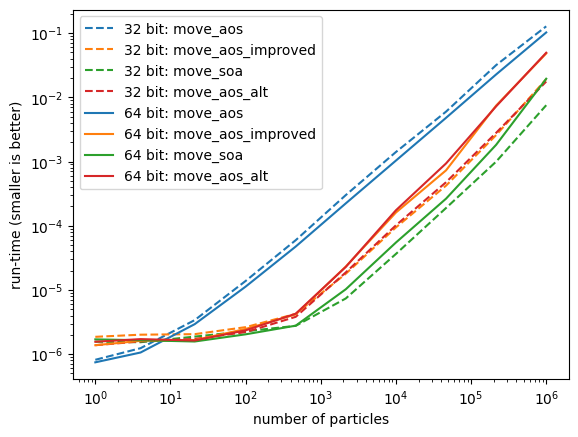

In [10]:
for bits in data:
    for ifn, fn in enumerate(fns):
        n, times = data[bits][fn]
        plt.plot(n, times, color=f"C{ifn}",
                 ls="-" if bits == 64 else "--",
                 label=f"{bits} bit: {fn}")
plt.legend()
plt.loglog()
plt.xlabel("number of particles")
plt.ylabel("run-time (smaller is better)");

Another way to present this is to look at the speed-up factor compared to the worst performing AoS implementation. We gain a factor of 40 in the best case.

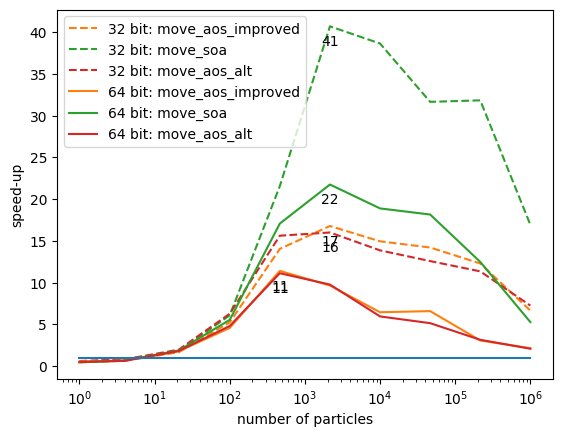

In [11]:
for bits in data:
    for ifn, fn in enumerate(fns):
        if fn == "move_aos":
            continue
        n, times = data[bits][fn]
        ratio = np.divide(data[bits]["move_aos"][1], times) 
        plt.plot(n, ratio, color=f"C{ifn}",
                 ls="-" if bits == 64 else "--",
                 label=f"{bits} bit: {fn}")
        i = np.argmax(ratio)
        plt.text(n[i], ratio[i] - 1, f"{ratio[i]:.0f}", ha="center", va="top")
plt.plot(n, np.ones_like(n), color="C0")
plt.legend()
plt.semilogx()
plt.xlabel("number of particles")
plt.ylabel("speed-up");

To understand where these improvements come from, we investigate the assembler code for each implementation and look for SIMD instructions (single input multiple data), which are often responsible for speed gains. We find that `move_soa` does not really stand out here. The speed does not come from the instructions used, it comes from optimized access patterns and pipelining.

In [12]:
import boost_histogram as bh

h = bh.Histogram(bh.axis.StrCategory([], growth=True), bh.axis.Integer(0, 3))

for ifn, fn in enumerate(fns):
    cmds = []
    for line in list(globals()[fn].inspect_asm().values())[0].split("\n"):
        line = line.strip("\t ")
        if line.startswith(".") or line.startswith("__"):
            continue
        if "\t" not in line:
            continue
        cmd = line.split("\t")[0]
        if not cmd.startswith("v"):
            continue
        if cmd.endswith("sd"):
            continue
        cmds.append(cmd)

    h.fill(cmds, ifn)

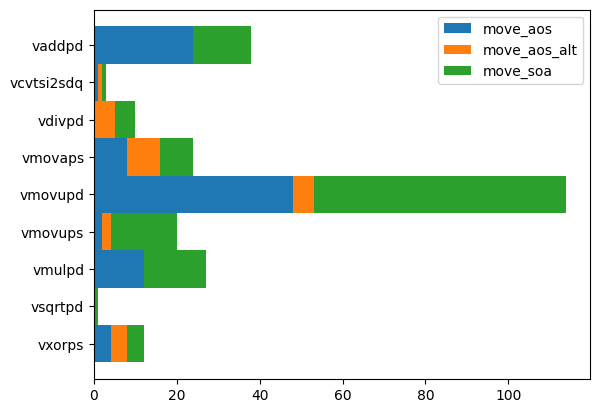

In [15]:
import matplotlib.pyplot as plt

xlabels = []
values = []

for x, v in sorted(zip(h.axes[0], h.values())):
    xlabels.append(x)
    values.append(v)

values = np.array(values)

xe = np.arange(len(xlabels) + 1)
v = 0
for ifn, fn in enumerate((move_aos, move_aos_alt, move_soa)):
    before = v
    v = v + values[:, ifn]
    plt.stairs(v, 1-xe, baseline=before, fill=True, label=fn.__name__, orientation="horizontal")
plt.legend()
plt.gca().yaxis.set_ticks(-np.arange(len(v)) + 0.5)
plt.gca().yaxis.set_ticklabels(xlabels);